# `SpenderQ` reconstructions

In [1]:
import os
import pickle
import numpy as np
import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

## `SpenderQ` models

In [3]:
niter = 3 

models = [] 
for imodel in range(5): 
    # load model
    _models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.edr.hiz.sa1p5sb1p5.i%i.%i.pt' % (niter, imodel))
    models.append(_models[0])

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [7]:
specs, recon, true_cont = [], [], []
redshifts, weights, tids, norms = [], [], [], []
for ibatch in range(5): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    specs.append(np.array(spec))
    tids.append(np.array(target_id))
    norms.append(np.array(norm))
    redshifts.append(np.array(z))
    weights.append(np.array(w))

    # spenderq reconstructions
    recons = [] 
    for imodel in range(5): 
        frecon = '/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.recons.npy' % (niter, imodel, ibatch)
        flatent = '/tigress/chhahn/spender_qso/train/edr.lfsc.rsnr.sa1p1sb0p8.i%i.%i_%i.latents.npy' % (niter, imodel, ibatch)
        if os.path.isfile(frecon): 
            _recon = np.load(frecon)
        else: 
            with torch.no_grad():
                models[imodel].eval()

                s = models[imodel].encode(spec)
                _recon = np.array(models[imodel].decode(s))

            np.save(flatent, s)
            np.save(frecon, _recon)
        recons.append(_recon)

    recon.append(np.mean(recons, axis=0))

specs = np.concatenate(specs, axis=0)
tids = np.concatenate(tids)
norms = np.concatenate(norms)
redshifts = np.concatenate(redshifts)
weights = np.concatenate(weights, axis=0)

recon = np.concatenate(recon, axis=0)

# load SpenderQ recon 
w_recon = np.array(models[0].wave_rest) # reconstruciton rest-frame wavelength 

In [8]:
A1100 = np.ones(recon.shape[0])
for i in range(recon.shape[0]): 
    A1100[i] = np.interp(1100, w_recon, recon[i])

In [9]:
n_recon = recon/A1100[:,None]

In [10]:
n_recon_q = np.quantile(n_recon, (0.025, 0.16, 0.5, 0.84, 0.975), axis=0)

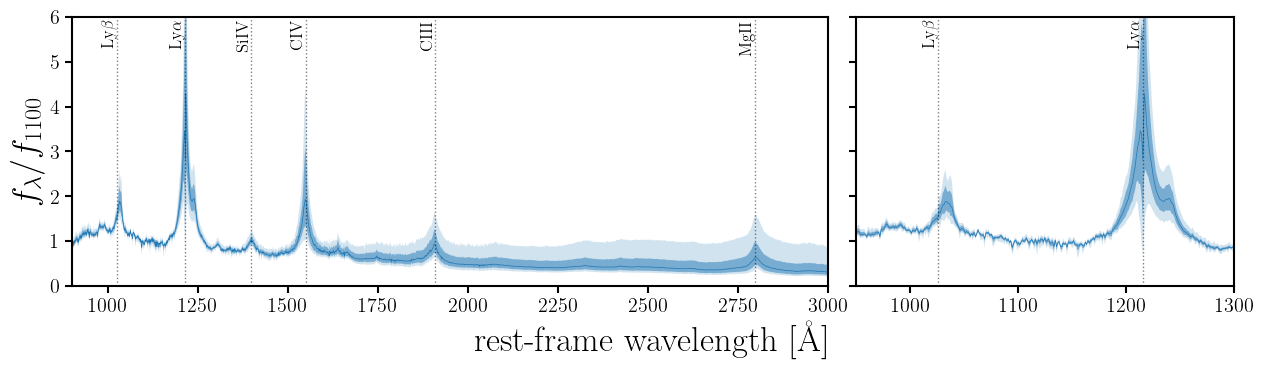

In [12]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 


sub = plt.subplot(gs[0])
sub.fill_between(w_recon[::5], n_recon_q[0][::5], n_recon_q[-1][::5], color='C0', edgecolor='none', alpha=0.2)
sub.fill_between(w_recon[::5], n_recon_q[1][::5], n_recon_q[-2][::5], color='C0', edgecolor='none', alpha=0.5)
sub.plot(w_recon[::5], n_recon_q[2][::5], c='C0', lw=0.5)

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1397.61, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1549.48, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1908.73, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(2799.12, color='k', linewidth=1, linestyle=':', alpha=0.5)

sub.text(1026, 5.9, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 5.9, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 5.9, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 5.9, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 5.9, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 5.9, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(900, 3000.)
sub.set_ylim(0., 6)
sub.set_ylabel(r'$f_\lambda/f_{1100}$', fontsize=25)


sub = plt.subplot(gs[1])
sub.fill_between(w_recon[::5], n_recon_q[0][::5], n_recon_q[-1][::5], color='C0', edgecolor='none', alpha=0.2)
sub.fill_between(w_recon[::5], n_recon_q[1][::5], n_recon_q[-2][::5], color='C0', edgecolor='none', alpha=0.5)
sub.plot(w_recon[::5], n_recon_q[2][::5], c='C0', lw=0.5)

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 5.9, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 5.9, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)


sub.set_xlim(950., 1300.)
sub.set_ylim(0., 6)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)
fig.savefig('quasar_spectra.pdf', bbox_inches='tight')

Text(0.5, 0, 'rest-frame wavelength [\\r{A}]')

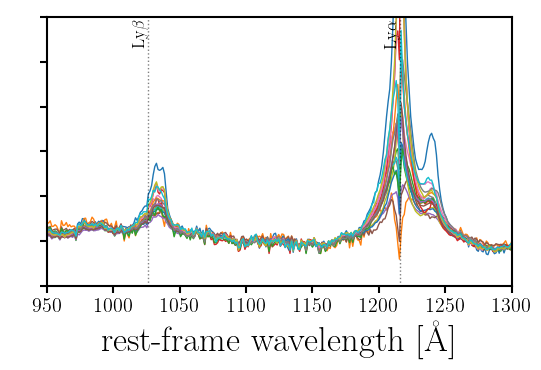

In [21]:
fig = plt.figure(figsize=(6,3.5))
sub = fig.add_subplot(111)

for igal in np.random.choice(np.arange(recon.shape[0]), size=20, replace=False): 
    sub.plot(w_recon[::5], n_recon[igal][::5], lw=1)
#sub.fill_between(w_recon[::5], n_recon_q[0][::5], n_recon_q[-1][::5], color='C0', edgecolor='none', alpha=0.2)
#sub.fill_between(w_recon[::5], n_recon_q[1][::5], n_recon_q[-2][::5], color='C0', edgecolor='none', alpha=0.5)
#sub.plot(w_recon[::5], n_recon_q[2][::5], c='C0', lw=0.5)

sub.axvline(1026, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.axvline(1216, color='k', linewidth=1, linestyle=':', alpha=0.5)
sub.text(1026, 5.9, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 5.9, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)


sub.set_xlim(950., 1300.)
sub.set_ylim(0., 6)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel(r'rest-frame wavelength [\r{A}]', fontsize=25)
#fig.savefig('quasar_spectra.pdf', bbox_inches='tight')